# Installing Transformer and imports

In [ ]:
!export http_proxy="http://proxy21.iitd.ac.in:3128"
!export https_proxy="http://proxy21.iitd.ac.in:3128"

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
import tensorflow as tf
import seaborn as sns
# import tensorflow_datasets as tfds
from bs4 import BeautifulSoup
from sklearn import metrics as sk_metrics
import nltk
import re
from sklearn.utils import shuffle
import tqdm as notebook_tqdm

2022-08-10 18:28:39.830015: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data read and split...for some accuracy numbers

In [2]:
col_list = ["id", "tweet", "labels"]
our_data = pd.read_csv("/home/shivangib/IRMIDIS-2022/2022/symptoms_train.csv",usecols=col_list)
df_test = pd.read_csv("/home/shivangib/IRMIDIS-2022/2022_test/symp_test.csv")
y_map = {
    'non-reporting': 0, 
    'third-party': 1, 
    'primary': 2,
    'secondary':3
}

our_data['Sentiment_Cat'] = our_data['labels'].map(y_map)

In [3]:
our_data

,id,tweet,labels,Sentiment_Cat
0,1322367936405921794,uh oh the coughs have started covid is taking ...,non-reporting,0
1,1262153405553946624,"Loss of smell, confusion, strokes: Does Covid-...",non-reporting,0
2,1324014644931878912,"""AI is being used to distinguish between asymp...",non-reporting,0
3,1313660639097823232,i was v ill for the last couple of days (high ...,non-reporting,0
4,1239223445306695680,Played warzone yesterday with a dude who caugh...,third-party,1
...,...,...,...,...
1569,1247792485239156738,@CCriadoPerez Totally. Murphy’s nose was runni...,third-party,1
1570,1295395700650528775,@kamera26 @Nicholaspkirby I just tested negati...,primary,2
1571,1241381235382984707,Lmao I have a cold or smth And every time I c...,primary,2
1572,1236525788360474629,"fuck the corona virus, all my homies got biebe...",secondary,3


In [4]:
df_test

,id,tweet
0,1242353332817137664t,If you think you have been exposed to COVID-19...
1,1244712715827982339t,"@timbovisser @BBCJohnBeattie Yes, myself, wife..."
2,1314693013810089984t,Lots of people I know having positive covid te...
3,1307860995692527616t,@lizzyp144 @TomAThakkar Okay but doesn’t COVID...
4,1277375421164613632t,We should have people w covid cough on white b...
...,...,...
395,1255420681581404163t,#bbcgms People who don't have COVID-19 cough s...
396,1331420575265394688t,"Fatigue, shortness of breath, muscle aches, he..."
397,1272691373645467653t,I woke up today from my nap and my throat was ...
398,1242065925337018369t,"#coronavirusindia It's just beginning, isolati..."


Uncomment if want testing results

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
df = our_data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_valid_index in split.split(df, df.Sentiment_Cat):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.Sentiment_Cat):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

print(train_set.shape)
print(test_valid_set.shape)
print(test_set.shape)
print(valid_set.shape)

df_train = train_set
df_valid = test_valid_set
# df_test = test_set
# df_valid = valid_set

(1416, 4)
(158, 4)
(79, 4)
(79, 4)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1416 entries, 853 to 1310
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1416 non-null   int64 
 1   tweet          1416 non-null   object
 2   labels         1416 non-null   object
 3   Sentiment_Cat  1416 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 55.3+ KB


In [7]:
df_train.Sentiment_Cat.value_counts()

0    732
2    393
1    177
3    114
Name: Sentiment_Cat, dtype: int64

In [9]:
# df_test.Sentiment_Cat.value_counts()

In [10]:
df_train.head()

,id,tweet,labels,Sentiment_Cat
853,1297524815125819392,my grandpa had a couple seizures yesterday and...,secondary,3
1290,1257891188637663232,@MumbaiPolice My family is in Chembur Camp Nea...,secondary,3
40,1249770473447206915,passed jeremy corbyn in the street today. i as...,third-party,1
877,1332394461150765065,@Mythsas I deal with social anxiety amongst ot...,primary,2
1475,1246793961366315009,The W.H.O is advising people to follow five si...,non-reporting,0


In [11]:
df_train['tweet'].iloc[0]

'my grandpa had a couple seizures yesterday and ended up in the hospital. but due to covid, no one could visit. he thankfully got to come home, but knowing that he woke up confused and not knowing what was going on with no one there for him breaks my heart.'

In [12]:
df_test.head()

,id,tweet
0,1242353332817137664t,If you think you have been exposed to COVID-19...
1,1244712715827982339t,"@timbovisser @BBCJohnBeattie Yes, myself, wife..."
2,1314693013810089984t,Lots of people I know having positive covid te...
3,1307860995692527616t,@lizzyp144 @TomAThakkar Okay but doesn’t COVID...
4,1277375421164613632t,We should have people w covid cough on white b...


In [ ]:
# y_map = {
#     'ProVax': 0, 
#     'AntiVax': 1, 
#     'Neutral': 2
# }

# df_train['Sentiment_Cat'] = df_train['label'].map(y_map)
# df_test['Sentiment_Cat'] = df_test['label'].map(y_map)

# Pre-processing

In [13]:
import sys
import re
# !pip install emoji --quiet
import emoji
# !pip install contractions --quiet
import contractions
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
import unicodedata

In [14]:
def cleaning(text):
  text= text.lower()
  text= emoji.demojize(text)
  text=contractions.fix(text)
  text=text.strip()
  text=text.replace('[^\w\s]','')
  text=re.sub(r'http\S+', '', text)
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
  text = REPLACE_BY_SPACE_RE.sub(' ' , text)
  text = BAD_SYMBOLS_RE.sub(' ',text)
  
  return text
df_train['tweet_cleaned'] = df_train['tweet'].apply(cleaning)
df_test['tweet_cleaned'] = df_test['tweet'].apply(cleaning)
df_valid['tweet_cleaned'] = df_valid['tweet'].apply(cleaning)
df_train['tweet_cleaned'].iloc[0]

/tmp/ipykernel_59608/2139545371.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet_cleaned'] = df_train['tweet'].apply(cleaning)
/tmp/ipykernel_59608/2139545371.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['tweet_cleaned'] = df_valid['tweet'].apply(cleaning)


'my grandpa had a couple seizures yesterday and ended up in the hospital  but due to covid  no one could visit  he thankfully got to come home  but knowing that he woke up confused and not knowing what was going on with no one there for him breaks my heart '

In [15]:
x_train, y_train = df_train['tweet_cleaned'].values, np.array(df_train['Sentiment_Cat'], dtype=np.int64)
# x_test, y_test = df_test['tweet_cleaned'].values, np.array(df_test['Sentiment_Cat'], dtype=np.int64)
x_valid, y_valid = df_valid['tweet_cleaned'].values, np.array(df_valid['Sentiment_Cat'], dtype=np.int64)


x_test = df_test['tweet_cleaned'].values

# Data Exploration

In [16]:
data = df_train
non_reporting_data = data[data['Sentiment_Cat'] == 0]
third_party_data = data[data['Sentiment_Cat'] == 1]
primary_data = data[data['Sentiment_Cat'] == 2]
secondary_data = data[data['Sentiment_Cat'] == 3]

#     'non-reporting': 0, 
#     'third-party': 1, 
#     'primary': 2,
#     'secondary':3

In [17]:
# df = Antivax_data
a=[]
for i in range(len(non_reporting_data)):
  a.append(len(non_reporting_data['tweet_cleaned'].iloc[i].split()))
print(max(a))
# df = Provax_data
b=[]
for i in range(len(third_party_data)):
  b.append(len(third_party_data['tweet_cleaned'].iloc[i].split()))
print(max(b))
# df = Neutral_data
c=[]
for i in range(len(primary_data)):
  c.append(len(primary_data['tweet_cleaned'].iloc[i].split()))
print(max(c))
d=[]
for i in range(len(secondary_data)):
  d.append(len(secondary_data['tweet_cleaned'].iloc[i].split()))
print(max(d))
print(len(non_reporting_data), len(third_party_data), len(primary_data), len(secondary_data))

95
61
69
76
732 177 393 114


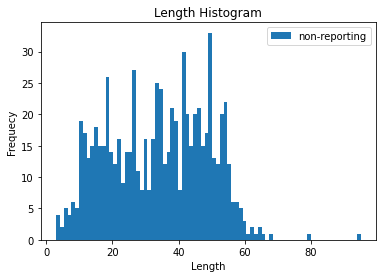

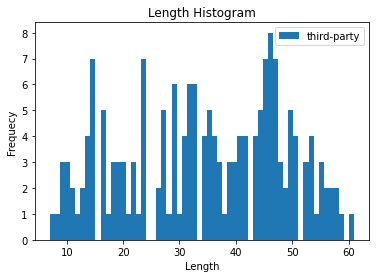

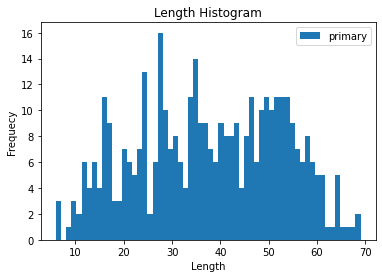

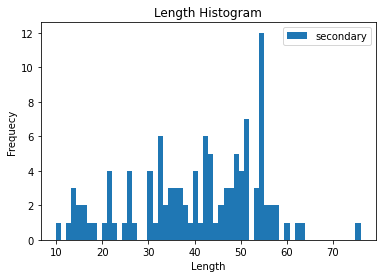

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
plt.hist(a,bins= 80, label = "non-reporting")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(b,bins= 60, label = "third-party")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(c, bins= 60, label = "primary")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(d, bins= 60, label = "secondary")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()

# BERT

In [19]:
from tokenizers import BertWordPieceTokenizer
import transformers
from transformers import RobertaTokenizer, TFRobertaModel


/home/shivangib/miniconda3/envs/irmidis/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased', lower=True)

# Save the loaded tokenizer locally
# tokenizer.save_pretrained('.')

# tokenizer = transformers.BertTokenizerFast.from_pretrained('.')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [21]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=200):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [22]:
max_len=60
x_train_enc = fast_encode(x_train, fast_tokenizer, maxlen=max_len)
x_valid_enc = fast_encode(x_valid, fast_tokenizer, maxlen=max_len)
x_test_enc = fast_encode(x_test, fast_tokenizer, maxlen=max_len)

In [23]:
NUM_CLASSES = df_train['Sentiment_Cat'].nunique()
print(NUM_CLASSES)
# bert_transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# bert_transformer = transformers.TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_CLASSES)
bert_transformer = transformers.TFBertForSequenceClassification.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2', num_labels=NUM_CLASSES)

# bert_transformer = transformers.TFRobertaForSequenceClassification.from_pretrained('vinai/bertweet-covid19-base-uncased', num_labels=NUM_CLASSES)

input = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
sequence_output = bert_transformer(input)[0]
# cls_token = sequence_output[:, 0, :]
# output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cls_token)

model = tf.keras.Model(inputs=input, outputs=sequence_output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

4


2022-08-10 18:31:00.247923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 18:31:02.328092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2022-08-10 18:31:02.329659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 29087 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2022-08-10 18:31:02.331020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 tf_bert_for_sequence_classi  TFSequenceClassifierOutp  335145988
 fication (TFBertForSequence  ut(loss=None, logits=(No           
 Classification)             ne, 4),                             
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
Total params: 335,145,988
Trainable params: 335,145,988
Non-trainable params: 0
_________________________________________________________________


In [25]:
# call backs
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    x_train_enc,
    y_train,
    batch_size=16,
    validation_data=(x_valid_enc, y_valid),
    epochs=50,
    callbacks=[early_stop_callback])

Epoch 1/50
89/89 [==============================] - 53s 346ms/step - loss: 1.1844 - accuracy: 0.5014 - val_loss: 1.1326 - val_accuracy: 0.5190
Epoch 2/50
89/89 [==============================] - 25s 284ms/step - loss: 1.0872 - accuracy: 0.5381 - val_loss: 0.9409 - val_accuracy: 0.6835
Epoch 3/50
89/89 [==============================] - 25s 283ms/step - loss: 0.8322 - accuracy: 0.7076 - val_loss: 0.6389 - val_accuracy: 0.7468
Epoch 4/50
89/89 [==============================] - 25s 281ms/step - loss: 0.5795 - accuracy: 0.8016 - val_loss: 0.4680 - val_accuracy: 0.8291
Epoch 5/50
89/89 [==============================] - 24s 272ms/step - loss: 0.4248 - accuracy: 0.8651 - val_loss: 0.4589 - val_accuracy: 0.8291
Epoch 6/50
89/89 [==============================] - 24s 270ms/step - loss: 0.3203 - accuracy: 0.8990 - val_loss: 0.3939 - val_accuracy: 0.8544
Epoch 7/50
89/89 [==============================] - 24s 265ms/step - loss: 0.2308 - accuracy: 0.9315 - val_loss: 0.4053 - val_accuracy: 0.8861

# Prediction 

In [26]:
ypred = model.predict(x_test_enc)
ypred
# df_test['ypred'] = np.argmax(ypred, axis=1)
# df_test['ypred_cat'] = np.where(df_test['ypred']>=0.5, 1, 0)
# df_test['ypred_cat'] = np.argmax(ypred, axis=1)
# df_test

13/13 [==============================] - 6s 169ms/step


array([[ 3.4673688 , -0.6698875 , -1.4941183 , -1.5463929 ],
       [-0.7333857 , -0.24591057,  0.309762  ,  1.9172816 ],
       [-0.6063697 ,  2.3212547 , -1.6215051 ,  0.5659699 ],
       ...,
       [ 0.52774984, -2.1582854 ,  4.0110645 , -2.283243  ],
       [ 3.4686642 , -0.17985068, -1.6604849 , -1.4901012 ],
       [ 2.9450486 ,  0.28529248, -1.7774847 , -0.9358548 ]],
      dtype=float32)

In [27]:
print(np.argmax(ypred, axis=1))

[0 3 1 0 0 2 0 1 0 2 0 0 0 0 0 2 0 0 3 0 0 0 0 2 2 0 0 3 2 0 0 0 3 0 0 2 1
 0 0 1 2 1 0 0 0 0 0 0 2 0 2 3 2 0 2 0 0 0 0 0 0 2 0 0 0 1 0 0 3 0 2 0 0 0
 0 0 0 3 2 1 2 2 0 0 0 0 2 2 0 0 0 2 0 0 0 0 0 2 0 0 1 1 2 2 1 2 0 0 1 0 0
 0 2 0 2 2 0 0 0 1 3 3 2 0 3 2 2 0 0 2 3 1 0 2 2 0 3 0 2 2 0 0 0 2 0 0 1 2
 1 0 1 0 0 0 2 3 0 2 2 0 1 2 1 2 0 3 0 0 2 2 0 0 2 0 0 0 0 2 0 0 1 1 2 2 0
 0 0 1 2 0 0 0 0 1 0 0 0 2 2 3 2 0 2 1 2 0 0 2 0 1 2 0 0 2 3 2 0 2 2 0 0 0
 2 2 0 0 0 0 3 0 2 0 0 0 2 0 2 1 0 2 0 0 0 0 1 2 2 2 2 0 0 0 0 0 0 0 0 2 0
 0 0 2 2 2 2 0 2 0 0 0 2 0 2 2 0 0 2 0 0 0 2 0 1 0 0 2 0 0 0 3 0 2 3 0 1 2
 0 0 0 2 2 1 0 0 0 0 1 0 3 0 2 3 0 0 2 0 0 2 3 0 0 0 0 0 0 0 1 0 2 0 0 0 3
 0 3 0 3 2 2 0 2 0 1 2 2 2 2 0 0 0 0 0 0 0 0 0 1 0 0 2 1 0 0 0 1 1 1 0 2 3
 1 0 0 2 0 0 0 0 1 0 0 0 0 2 0 2 3 2 2 0 0 2 2 0 2 0 0 2 0 0]


In [28]:
df_test['pred'] = np.argmax(ypred, axis=1)
df_test

,id,tweet,tweet_cleaned,pred
0,1242353332817137664t,If you think you have been exposed to COVID-19...,if you think you have been exposed to covid 19...,0
1,1244712715827982339t,"@timbovisser @BBCJohnBeattie Yes, myself, wife...",timbovisser bbcjohnbeattie yes myself wife...,3
2,1314693013810089984t,Lots of people I know having positive covid te...,lots of people i know having positive covid te...,1
3,1307860995692527616t,@lizzyp144 @TomAThakkar Okay but doesn’t COVID...,lizzyp144 tomathakkar okay but does not covi...,0
4,1277375421164613632t,We should have people w covid cough on white b...,we should have people w covid cough on white b...,0
...,...,...,...,...
395,1255420681581404163t,#bbcgms People who don't have COVID-19 cough s...,bbcgms people who do not have covid 19 cough ...,0
396,1331420575265394688t,"Fatigue, shortness of breath, muscle aches, he...",fatigue shortness of breath muscle aches he...,0
397,1272691373645467653t,I woke up today from my nap and my throat was ...,i woke up today from my nap and my throat was ...,2
398,1242065925337018369t,"#coronavirusindia It's just beginning, isolati...",coronavirusindia it is just beginning isolat...,0


In [29]:
y_map_inv = {
    0: 'non-reporting',
    1: 'third-party',
    2: 'primary',
    3:'secondary'
}
df_test['pred'] = df_test['pred'].map(y_map_inv)

In [30]:
# df_test1["id"]= df_test["id"]
df_test.to_csv("DATA@IITD_task2_run1.csv")

In [31]:
df_test.pred.value_counts()

non-reporting    226
primary          108
third-party       39
secondary         27
Name: pred, dtype: int64

In [ ]:
y_map_inv = {
    0: 'non-reporting',
    1: 'third-party',
    2: 'primary',
    3:'secondary'
}

#     'non-reporting': 0, 
#     'third-party': 1, 
#     'primary': 2,
#     'secondary':3

# y_map = {
#     'ProVax': 0, 
#     'AntiVax': 1, 
#     'Neutral': 2
# }

sns.heatmap(
    pd.crosstab(df_test['ypred'].map(y_map_inv), df_test['Sentiment_Cat'].map(y_map_inv)),
    annot=True,
    fmt='0.0f',
    cbar=False,
    linewidth=2,
    cmap='coolwarm'     
)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix');

In [ ]:
y_test = df_test['Sentiment_Cat'].map(y_map_inv)
y_pred = df_test['ypred'].map(y_map_inv)
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4']))
